In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import partial

import haiku as hk # DeepMind's neural network library
import optax # Gradient-based optimization in JAX

from probjax.utils.odeint import odeint
from probjax.nn.transformers import Transformer
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.loss_fn import denoising_score_matching_loss
from probjax.distributions.sde import VPSDE, VESDE
from probjax.distributions import Empirical, Independent

from scoresbibm.utils.plot import use_style

from sbi.analysis import pairplot
import numpy as np

In [2]:
# Arrays will always land on the device first in the list.
# Device handling is automatic, depending for which device the function is compiled or where the data is placed.
jax.devices()

[cuda(id=0)]

In [3]:
# Set random key
key = jax.random.PRNGKey(0)

# Toy problem

This is a simple toy problem to test the functionality of the `scoresbi` method.
$$ \theta \sim \mathcal{N}(0, 3^2) \text{ and } x \sim \mathcal{N}(2\cdot\sin(\theta); 0.5^2) $$

We assign to each variable an ID, here $id(\theta) = 0$ and $id(x) = 1$. In total, we have $n=2$ variables thus nodes.

In [5]:
def generate_data(key, n):
    key1, key2, key3 = jrandom.split(key,3)
    theta1 = jrandom.normal(key1, (n, 1))  * 3 # Some prior on a parameter
    x1 = 2*jnp.sin(theta1) + jrandom.normal(key2, (n, 1)) * 0.5 # Some data generated from the parameter 
    x2 = 0.1*theta1**2 + 0.5*jnp.abs(x1)*jrandom.normal(key3, (n, 1)) # Some data generated from the parameter
    return jnp.concatenate([theta1,x1, x2], axis=1).reshape(n, -1, 1)

def log_potential(theta1, x1, x2, sigma_x1=0.5, sigma_x2=0.5, mean_loc=0.0, mean_scale=3.0  ):
    log_prob_theta = jax.scipy.stats.norm.logpdf(theta1, mean_loc, mean_scale)
    if x1 is not None:
        log_prob_x1 = jax.scipy.stats.norm.logpdf(x1, 2*jnp.sin(theta1), sigma_x1)
    else:
        log_prob_x1 = 0
    if x2 is not None:
        log_prob_x2 = jax.scipy.stats.norm.logpdf(x2, 0.1*theta1**2,  sigma_x2*jnp.abs(x1))
    else:
        log_prob_x2 = 0
    
    return log_prob_theta + log_prob_x1 + log_prob_x2
    

data = generate_data(jrandom.PRNGKey(1), 100000)  # Shape: (n, nodes, dim) here dim = 1
nodes_max = data.shape[1]
node_ids = jnp.arange(nodes_max)

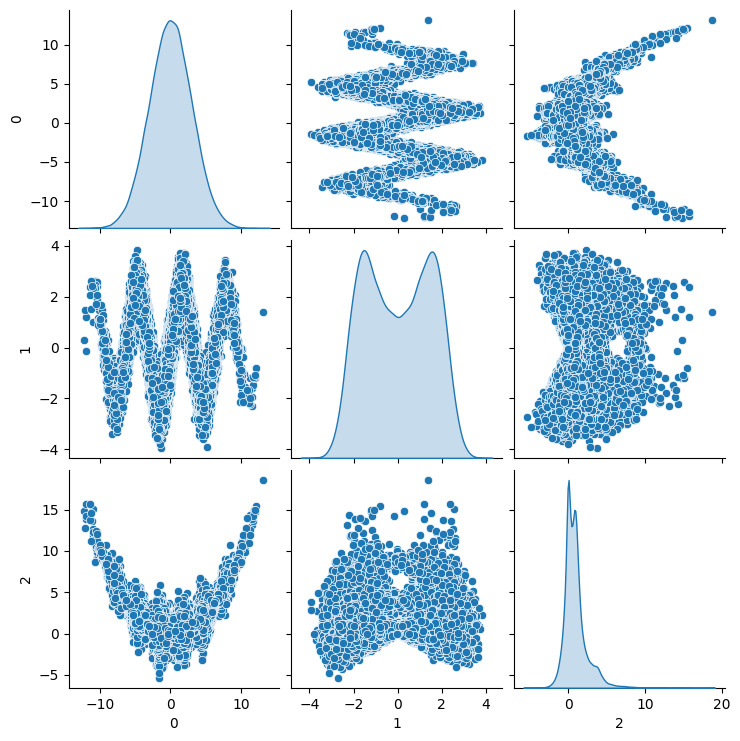

In [6]:
sns.pairplot(pd.DataFrame(data[:, :, 0]), diag_kind="kde")

## Setting up the diffusion process

We will use the VPSDE i.e. the variance preserving stochastic differential equation. 

In [7]:

# VPSDE 
T = 1.
T_min = 1e-4
sigma_min = 0.001
sigma_max = 10.

p0 = Independent(Empirical(data), 1) # Empirical distribution of the data
sde = VESDE(p0, sigma_min=sigma_min , sigma_max=sigma_max)

def output_scale_fn(t, x):
    scale = sde.marginal_stddev(t, jnp.ones_like(x))
    return (1/scale * x).reshape(x.shape)

## The model

This can be seperated into two parts:

- **Tokenizer**: Jointly embeds x, node_ids and the condition_mask as a single vector aka token.
    - **Value embedding**: Embeds the value of the variable.
    - **Node embedding**: Embeds the node id.
    - **Condition embedding**: Embeds the condition mask.
- **Transformer**: A transformer that takes the tokens as input and outputs the score for each node. 
    - **num_heads**: Number of heads in the multi-head attention.
    - **attn_size**: Size of the attention i.e. the query and key are projected to this size.
    - **num_layers**: Number of layers in the transformer.
    - **widening_factor**: Factor by which the MLP hidden size is increased in each layer.

In [8]:

def model(t, x, node_ids, condition_mask, edge_mask=None):
    batch_size, seq_len, node_dim = x.shape
    condition_mask = condition_mask.astype(jnp.int32).reshape(-1,seq_len, 1)
    node_ids = node_ids.reshape(-1,seq_len)
    t = t.reshape(-1,1, 1)
    
    # Diffusion time embedding net (here we use a Gaussian Fourier embedding)
    embedding_time = GaussianFourierEmbedding(64)  # Time embedding net
    time_embeddings = embedding_time(t)
    
    # Tokinization part --------------------------------------------------------------------------------
    dim_value = 20
    dim_id = 20
    dim_condition = 10
    embedding_net_value = lambda x: jnp.repeat(x, dim_value, axis=-1)    # Value embedding net (here we just repeat the value)
    embedding_net_id = hk.Embed(nodes_max, dim_id, w_init=hk.initializers.RandomNormal(stddev=3.))   # Node id embedding nets (here we use a learnable random embedding vector)
    condition_embedding = hk.get_parameter("condition_embedding", shape=(1,1,dim_condition), init=hk.initializers.RandomNormal(stddev=0.01)) # Condition embedding (here we use a learnable random embedding vector)
    condition_embedding = condition_embedding * condition_mask # If condition_mask is 0, then the embedding is 0, otherwise it is the condition_embedding
    condition_embedding = jnp.broadcast_to(condition_embedding, (batch_size, seq_len, dim_condition))
    
    # Embed inputs and broadcast
    value_embeddings = embedding_net_value(x)
    id_embeddings = embedding_net_id(node_ids)
    value_embeddings, id_embeddings = jnp.broadcast_arrays(value_embeddings, id_embeddings)
    
    # Concatenate embeddings
    x_encoded = jnp.concatenate([value_embeddings, id_embeddings, condition_embedding], axis=-1)
    #x_encoded = x_encoded + condition_embedding # Add condition embedding (here we also could concatenate it)
    
    # Transformer part --------------------------------------------------------------------------------
    model = Transformer(num_heads=2, num_layers=2, attn_size=10, widening_factor=3) 
    
    # Encode - here we just use a transformer to transform the tokenized inputs into a latent representation
    if edge_mask is None:
        edge_mask = (jnp.eye(seq_len, dtype=jnp.int32) + node_ids[..., :, None] != node_ids[..., None, :]).astype(jnp.bool_) # Nodes with different ids are connected, otherwise not.
    h = model(x_encoded, context=time_embeddings, mask=edge_mask)

    # Decode - here we just use a linear layer to get the score estimate (typically it is good to scale the output, with the variance of the sde at the time point t, but here we omit it for simplicity)
    out = hk.Linear(1)(h)
    out = output_scale_fn(t, out)
    return out


In [9]:
# In Haiku, we need to initialize the model first, before we can use it.
init, model_fn = hk.without_apply_rng(hk.transform(model)) # Init function initializes the parameters of the model, model_fn is the actual model function (which takes the parameters as first argument, hence is a "pure function")
params = init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))

In [10]:
# Here we can visualize the whole computation graph, which is quite large. So here we just show all the parameters.
# import graphviz
# dot = hk.experimental.to_dot(model_fn)(params,jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))
# graphviz.Source(dot)
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters

Total number of parameters:  45774


{'embed': {'embeddings': (3, 20)},
 'gaussian_fourier_embedding': {'B': (33, 1)},
 'linear': {'b': (1,), 'w': (50, 1)},
 'transformer/layer_norm': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_1': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_2': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_3': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_4': {'offset': (50,), 'scale': (50,)},
 'transformer/linear': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_1': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_2': {'b': (50,), 'w': (64, 50)},
 'transformer/linear_3': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_4': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_5': {'b': (50,), 'w': (64, 50)},
 'transformer/multi_head_attention/key': {'b': (20,), 'w': (50, 20)},
 'transformer/multi_head_attention/linear': {'b': (50,), 'w': (20, 50)},
 'transformer/multi_head_attention/query': {'b': (20,), 'w': (50, 20)},
 'transformer/multi

## Writing down the loss
* What we want
    * Correct marginals $p(\theta), p(x)$
    * Correct conditionals $p(\theta|x), p(x|\theta)$
    * Correct joint $p(\theta|x)$
    
* Base loss still same, but with some modifications
$$ \mathcal{L}(\phi) = \mathbb{E}_{t \sim Unif(0,1)} \left[ \lambda(t) \mathbb{E}_{x_0, x_t \sim p(x_0)p(x_t|x_0)}\left[ || s_\phi(x_t, t) - \nabla_{x_t} \log p(x_t|x_0)||_2^2 \right] \right] $$
 

In [11]:
def weight_fn(t):
    return jnp.clip(sde.diffusion(t, jnp.ones((1,1,1)))**2, 1e-4)

def loss_fn(params, key, batch_size= 1024):

    rng_model, rng_time, rng_sample, rng_data, rng_sub, rng_condition = jax.random.split(key, 6)
    
    # Generate data and random times
    times = jax.random.uniform(rng_time, (batch_size, 1, 1), minval=T_min, maxval=1.0)
    batch_xs = generate_data(rng_data, batch_size) # n, T_max, 1

    # Node ids (can be subsampled but here we use all nodes)
    ids = node_ids
    

    # Condition mask -> randomly condition on some data -> Sample more frequently no condition
    condition_mask = jax.random.bernoulli(rng_condition, 0.1, shape=(batch_xs.shape[0], batch_xs.shape[1]))
    condition_mask = condition_mask[..., None]
    

    edge_mask1 = jnp.repeat(jnp.eye(batch_xs.shape[1], dtype=jnp.int32)[None, ...],batch_size//5, axis=0) # Marginal consistency
    edge_mask2 = jax.random.choice(rng_sub, jnp.array([jnp.array([[1,0,1], [0,1,0],[1,0,1]]), jnp.array([[1,1,0], [1,1,0],[0,0,1]])]), shape=(batch_size//5,), axis=0) # Subgraph consistency i.e. marginalizing x_1 and x_2 out
    edge_mask3 = jnp.repeat(jnp.ones((batch_xs.shape[1],batch_xs.shape[1]), dtype=jnp.int32)[None, ...],batch_size - 2*(batch_size//5), axis=0) # Joint consistency
    edge_masks = jnp.concatenate([edge_mask1, edge_mask2, edge_mask3], axis=0)


    # Forward diffusion, do not perturb conditioned data
    loss = denoising_score_matching_loss(params, rng_sample, times, batch_xs, condition_mask, model_fn= model_fn, mean_fn=sde.marginal_mean, std_fn = sde.marginal_stddev, weight_fn=weight_fn,node_ids=ids, condition_mask=condition_mask, edge_mask=edge_masks)
    
    return loss


In [12]:
@partial(jax.pmap, axis_name="num_devices")
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng)
    
    loss = jax.lax.pmean(loss, axis_name="num_devices")
    grads = jax.lax.pmean(grads, axis_name="num_devices")
    
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [13]:
schedule = optax.linear_schedule(1e-3, 0, 1500*10, 1500*10)
optimizer = optax.chain(optax.adaptive_grad_clip(10.), optax.adam(schedule))
opt_state = optimizer.init(params)

In [14]:
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)

## Train

In [15]:
key = jrandom.PRNGKey(0)
for _ in range(20):
    l = 0
    for i in range(1500):
        key, subkey = jrandom.split(key)
        loss, replicated_params, replicated_opt_state = update(replicated_params, jax.random.split(subkey, (n_devices,)), replicated_opt_state)
        l += loss[0] /1500
    print(l)
params = jax.tree_map(lambda x: x[0], replicated_params)

46.407734
45.73902
45.553635
45.548134
45.39873
45.373867
45.33962
45.320415
45.370777
45.29802
45.317894
45.19129
45.137184
45.1838
45.183506
45.06145
44.96897
45.170475
45.06938
44.938934


In [16]:
params = jax.tree_map(lambda x: x[0], replicated_params)

## Sampling using backward SDE

In [17]:
from functools import partial
from probjax.utils.sdeint import sdeint

condition_mask = jnp.zeros((nodes_max,))
condition_value = jnp.zeros((nodes_max,))

# Reverse SDE drift
def drift_backward(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    score = score_fn(params, t.reshape(-1, 1, 1), x.reshape(-1, len(node_ids), 1), node_ids,condition_mask[:len(node_ids)], edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    if replace_conditioned:
        f = f * (1-condition_mask[:len(node_ids)])
    
    return f

# Reverse SDE diffusion
def diffusion_backward(t,x, node_ids=node_ids,condition_mask=condition_mask, replace_conditioned=True):
    #t = T - t
    b =  sde.diffusion(t,x) 
    if replace_conditioned:
        b = b * (1-condition_mask[:len(node_ids)])
    return b

In [378]:

end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))

def sample_fn(key, shape, node_ids=node_ids, time_steps=500, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    condition_mask = condition_mask[:len(node_ids)]
    key1, key2 = jrandom.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]
    
    if replace_conditioned:
        x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Sove backward sde
    keys = jrandom.split(key2, shape)
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn, replace_conditioned=replace_conditioned), lambda t, x: diffusion_backward(t, x, node_ids, condition_mask, replace_conditioned=replace_conditioned), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys


In [379]:
# Marginal estimation alone
marginal_samples1  = sample_fn(jrandom.PRNGKey(0), (2000,), jnp.array([0,]), condition_mask=jnp.zeros((1,), dtype=int), condition_value=jnp.zeros((1,)), time_steps=500)
marginal_samples2  = sample_fn(jrandom.PRNGKey(0), (2000,), jnp.array([1,]), condition_mask=jnp.zeros((1,), dtype=int), condition_value=jnp.zeros((1,)), time_steps=500)
marginal_samples3 = sample_fn(jrandom.PRNGKey(0), (2000,), jnp.array([2,]), condition_mask=jnp.zeros((1,), dtype=int), condition_value=jnp.zeros((1,)), time_steps=500)

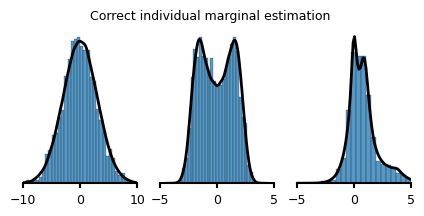

In [380]:
with use_style("pyloric"):
    fig, ax = plt.subplots(1,3, figsize=(5,2))
    sns.histplot(marginal_samples1[:, -1, 0], bins=50, ax=ax[0], stat="density")
    sns.histplot(marginal_samples2[:, -1, 0], bins=50, ax=ax[1], stat="density")
    sns.histplot(marginal_samples3[:, -1, 0], bins=50, ax=ax[2], stat="density")
    sns.kdeplot(data[:, 0, 0], ax=ax[0], color="black", linewidth=2)
    sns.kdeplot(data[:, 1, 0], ax=ax[1], color="black", linewidth=2)
    sns.kdeplot(data[:, 2, 0], ax=ax[2], color="black", linewidth=2)
    
    ax[0].set_xlim(-10,10)
    ax[1].set_xlim(-5,5)
    ax[2].set_xlim(-5,5)
    fig.suptitle("Correct individual marginal estimation")
    for ax in ax:
        ax.yaxis.set_visible(False)
        # remove y spines
        ax.spines['left'].set_visible(False)
        
    fig.savefig("correct_marginal_estimation.svg")
        


In [381]:
# Full joint estimation
samples = sample_fn(jrandom.PRNGKey(0), (10000,), node_ids, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), time_steps=500)

In [382]:
samples.shape

(10000, 500, 3)

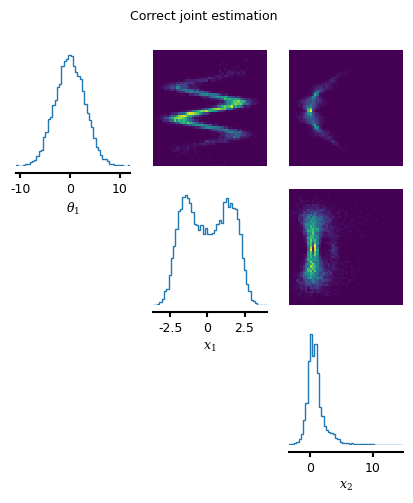

In [383]:
with use_style("pyloric"):
    fig,axes = pairplot(np.array(samples[:,-1,:]), figsize=(5,5), labels=["$\\theta_1$", "$x_1$", "$x_2$"], diag_kind="kde", color="black", linewidth=2)
    fig.suptitle("Correct joint estimation")
    fig.savefig("correct_joint_estimation_with_correct_marginals.svg")

In [328]:
with jax.default_device(jax.devices("cpu")[0]):
    potential_fn = jax.vmap(jax.scipy.stats.gaussian_kde(data[:,[0,1], 0].T, bw_method="silverman"))
    x = jnp.linspace(data[:, 0, 0].min(), data[:, 0, 0].max(), 200)
    y = jnp.linspace(data[:, 1, 0].min(), data[:, 1, 0].max(), 200)
    X, Y = jnp.meshgrid(x, y)
    pos = jnp.dstack((X, Y))
    Z_true = potential_fn(pos.reshape(-1,2)).reshape(200,200)

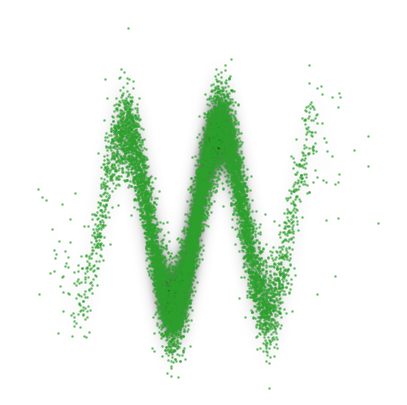

In [332]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(5,5))
    plt.contourf(X,Y,Z_true, cmap="Greys", levels=200, vmin=0)
    plt.scatter(samples[:, -1, 0], samples[:, -1, 1], s=1, alpha=0.5, color="tab:green")
    plt.axis("off")
    plt.savefig("scoresbi_theta_x1.png", dpi=300, bbox_inches="tight", pad_inches=0.0)

In [334]:
with jax.default_device(jax.devices("cpu")[0]):
    potential_fn = jax.vmap(jax.scipy.stats.gaussian_kde(data[:,[0,2], 0].T, bw_method="silverman"))
    x = jnp.linspace(data[:, 0, 0].min(), data[:, 0, 0].max(), 200)
    y = jnp.linspace(data[:, 2, 0].min(), data[:, 2, 0].max(), 200)
    X, Y = jnp.meshgrid(x, y)
    pos = jnp.dstack((X, Y))
    Z = potential_fn(pos.reshape(-1,2)).reshape(200,200)

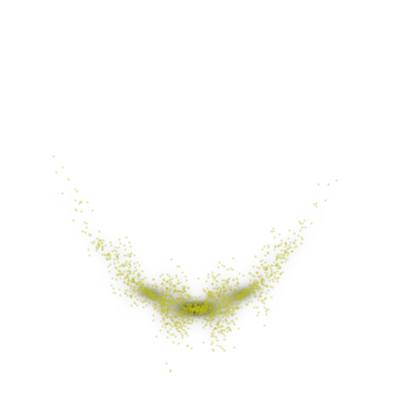

In [107]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(5,5))
    plt.contourf(X,Y,Z, cmap="Greys", levels=200, vmin=0)
    plt.scatter(samples[:, -1, 0], samples[:, -1, 2], s=1, alpha=0.2, color="tab:olive")
    plt.axis("off")
    plt.savefig("figures/scoresbi_theta_x2.png", dpi=300, bbox_inches="tight", pad_inches=0.0)

In [41]:
# Joint marginals
samples_subjoint = sample_fn(jrandom.PRNGKey(0), (2000,), jnp.array([0,1]), condition_mask=jnp.zeros((2,), dtype=int), condition_value=jnp.zeros((2,)), time_steps=500)

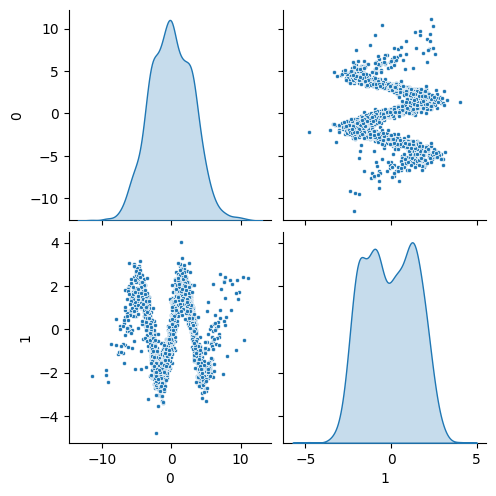

In [42]:
sns.pairplot(pd.DataFrame(samples_subjoint[:, -1, :]), diag_kind="kde", markers=".")

### Arbitrary conditional distributions

In [411]:


potential_theta = partial(log_potential, x1=data[0, 1, 0], x2=data[0, 2, 0])



In [412]:
x = jnp.linspace(-10, 10, 1000)
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


/tmp/ipykernel_5056/1890475010.py:5: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  potential_post = potential_post / jnp.trapz(potential_post, x=x)


In [419]:
# Full conditional estimation
samples = sample_fn(jrandom.PRNGKey(0), (10000,), node_ids, condition_mask=jnp.array([0,1,1], dtype=int), condition_value=data[0,:,0], time_steps=1000)

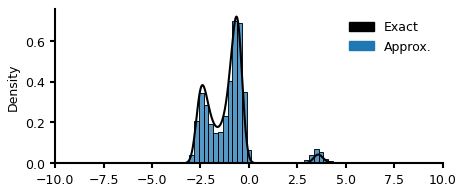

In [422]:

import matplotlib.patches as mpatches
samples_theta = samples[...,-1, 0]
with use_style("pyloric"):
    fig = plt.figure(figsize=(5, 2))
    sns.histplot(samples_theta, bins=40, stat="density")
    plt.plot(x, potential_post, color="black", label="True posterior")
    exact_patch = mpatches.Patch(color='black', label='Exact')
    approx_patch = mpatches.Patch(color='C0', label='Approx.')
    plt.legend(handles=[exact_patch, approx_patch])
    plt.xlim(-10, 10)
    plt.savefig("scoresbi_theta_full_posterior.png", dpi=300, bbox_inches="tight", pad_inches=0.0)

In [401]:
# Not full
samples = sample_fn(jrandom.PRNGKey(0), (10000,), node_ids, condition_mask=jnp.array([0,1,0], dtype=int), condition_value=data[0,:,0], time_steps=500)

In [402]:
x = jnp.linspace(-10, 10, 1000)

potential_theta = partial(log_potential, x1=data[0, 1, 0], x2=None)
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


/tmp/ipykernel_5056/2657653685.py:7: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  potential_post = potential_post / jnp.trapz(potential_post, x=x)


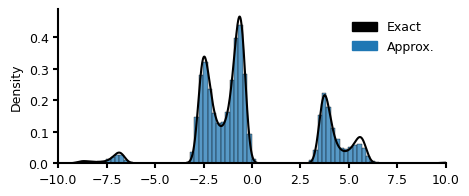

In [406]:

import matplotlib.patches as mpatches
samples_theta = samples[...,-1, 0]
with use_style("pyloric"):
    fig = plt.figure(figsize=(5, 2))
    sns.histplot(samples_theta, bins=100, stat="density")
    plt.plot(x, potential_post, color="black", label="True posterior")
    exact_patch = mpatches.Patch(color='black', label='Exact')
    approx_patch = mpatches.Patch(color='C0', label='Approx.')
    plt.legend(handles=[exact_patch, approx_patch])
    plt.xlim(-10, 10)
    #plt.savefig("figures/scoresbi_theta_posterior.png", dpi=300, bbox_inches="tight", pad_inches=0.0)

### Classifier free guidance

We can not conly do conitioning on $p(\theta, x)$ but also on i.e. $p(\theta|x)p(x|\theta)^\alpha$ or $p(x|\theta)p(\theta|x)^\alpha$ by modifying the score on inference time.

* Change the prior $p(\theta)$ -> $p(\theta)^\alpha p(x|\theta)$
* Change the likelihood $p(x|\theta)$ -> $p(\theta)p(x|\theta)^\alpha$

We can also condition on e.g. intervals
$$ p(\theta|x \in [0, 1]) \propto p(\theta)p(x \in [0, 1]|\theta) = p(\theta)p(x|\theta) I(x \in [0,1]) $$

Unfortunatly $I(x \in [0,1])$ does not have a gradient. But we only need to know a trajactory that transforms into $I(x \in [0,1])$ as $t \rightarrow 0$. This can be done by using a sigmoid function.

In [423]:

def s(t):
    t = jnp.atleast_1d(t)
    return jnp.exp(-t**2*5)*100

def log_linear_fn_approximation(t,x, a):
    #scale = jnp.exp(-t**2*5)*max_steepness
    scale = s(t)
    a = a.reshape(-1,x.shape[1],1)
    x1 = jax.nn.log_sigmoid(scale *jnp.sum((x * a), axis=1))
    x2 = jax.nn.log_sigmoid(-scale *jnp.sum((x * a), axis=1))
    return x1 + x2

def log_polytope_fn_approximation(t,x, A):
    scale = s(t)
    a = x.reshape(-1, x.shape[1])
    constraint = jax.nn.relu(scale * (jnp.matmul(a, A.T) - 1.)).max(axis=-1)
    constraint = jax.nn.log_sigmoid(-constraint) 
    return constraint


def log_step_fun(t,x,a,b):
    scale = s(t)
    x1 = jax.nn.log_sigmoid(jnp.sum(scale * (x - a), axis=-1))
    x2 = jax.nn.log_sigmoid(jnp.sum(-scale * (x - b), axis=-1))

    return x1 + x2


step_fn_score = jax.grad(lambda *args: log_step_fun(*args).sum(), argnums=1)
linear_fn_score = jax.grad(lambda *args: log_linear_fn_approximation(*args).sum(), argnums=1)
polytope_fn_score = jax.grad(lambda *args: log_polytope_fn_approximation(*args).sum(), argnums=1)
    

In [424]:

def interval_score(params, t, x, node_ids, condition_mask, edge_mask, a,b):

    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids), 1)
    score = model_fn(params,t, x, node_ids=node_ids, condition_mask=jnp.zeros_like(condition_mask), edge_mask=edge_mask)
    tweedies_x0_estimator = (x + sde.marginal_stddev(t, jnp.array([1.]))**2 * score)/sde.marginal_mean(t, jnp.array([1.])) # Predict x0
    interval_score_est = step_fn_score(t,tweedies_x0_estimator,a,b).reshape(-1, len(node_ids), 1) * condition_mask.reshape(-1, len(node_ids), 1)
    print(interval_score_est, score)

    return score + interval_score_est

def linear_score(params, t, x, node_ids, condition_mask, edge_mask, a):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids), 1)
    score = model_fn(params,t, x, node_ids=node_ids, condition_mask=jnp.zeros_like(condition_mask), edge_mask=edge_mask)
    tweedies_x0_estimator = (x + sde.marginal_stddev(t, jnp.array([1.]))**2 * score)/sde.marginal_mean(t, jnp.array([1.])) # Predict x0
    linear_score_est = linear_fn_score(t,tweedies_x0_estimator,a) * condition_mask.reshape(-1, len(node_ids), 1)

    return score + linear_score_est

def polytope_score(params, t, x,  node_ids, condition_mask, edge_mask, A):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids), 1)
    score = model_fn(params,t, x, node_ids=node_ids, condition_mask=jnp.zeros_like(condition_mask), edge_mask=edge_mask)
    tweedies_x0_estimator = (x + sde.marginal_stddev(t, jnp.array([1.]))**2 * score)/sde.marginal_mean(t, jnp.array([1.])) # Predict x0
    polytope_score_est = polytope_fn_score(t,tweedies_x0_estimator,A) #* condition_mask.reshape(-1, len(node_ids), 1)

    return score + polytope_score_est

score_fn1 = partial(interval_score, a=2.*jnp.ones(1), b=jnp.ones(1)*3)
score_fn3 = partial(linear_score, a=jnp.array([1., 5.]))
score_fn4 = partial(polytope_score, A=0.3*jax.random.normal(jrandom.PRNGKey(0), (8,2)))

In [425]:
def plot2(data, samples, t=-1, alpha_scatter=0.1):
    fig = sns.jointplot(x = data[:samples.shape[0], 0, 0], y=data[:samples.shape[0], 1, 0], color="C2", alpha=0.1)
    
    
    fig.x = samples[:, t, 0]
    fig.y = samples[:, t, 1]
    fig.plot_joint(plt.scatter, alpha=alpha_scatter)
    
    if jnp.all(condition_mask[0] == 0):
        sns.histplot(samples[:, -1, 0], ax=fig.ax_marg_x, color="C0")
    else:
        fig.ax_marg_x.vlines(condition_value[0], 0, samples.shape[0], color="C0", lw=5)
        
    if jnp.all(condition_mask[1] == 0):
        plt.sca(fig.ax_marg_x)
        sns.histplot(y=samples[:, -1, 1], ax=fig.ax_marg_y, color="C0", orientation="horizontal")
    else:
        fig.ax_marg_y.hlines(condition_value[1], 0, samples.shape[0], color="C0", lw=5)
        
    return fig, [fig.ax_joint, fig.ax_marg_x, fig.ax_marg_y]

In [426]:

samples1 = sample_fn(jrandom.PRNGKey(0), (1000,), time_steps=1000, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), score_fn=score_fn1, replace_conditioned=False)

Traced<ShapedArray(float32[1,2,1])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(float32[1,2,1])>with<DynamicJaxprTrace(level=2/0)>
Traced<ShapedArray(float32[1,2,1])>with<DynamicJaxprTrace(level=4/0)> Traced<ShapedArray(float32[1,2,1])>with<DynamicJaxprTrace(level=4/0)>


In [427]:

samples2 = sample_fn(jrandom.PRNGKey(0), (1000,), time_steps=1000, node_ids=jnp.array([0,1]), condition_mask=jnp.array([1,1], dtype=int), score_fn=score_fn3, replace_conditioned=False)

In [428]:
samples3 = sample_fn(jrandom.PRNGKey(0), (1000,), time_steps=1000, node_ids=jnp.array([0,1]), condition_mask=jnp.array([1,1], dtype=int), score_fn=score_fn4, replace_conditioned=False)

In [429]:
with jax.default_device(jax.devices("cpu")[0]):
    def pot(x):
        return jnp.exp(log_polytope_fn_approximation(0.001, x, 0.3*jax.random.normal(jrandom.PRNGKey(0), (8,2))))


    potential_fn = jax.vmap(jax.scipy.stats.gaussian_kde(data[:,[0,1], 0].T, bw_method="silverman"))
    x = jnp.linspace(data[:, 0, 0].min(), data[:, 0, 0].max(), 200)
    y = jnp.linspace(data[:, 1, 0].min(), data[:, 1, 0].max(), 200)
    X, Y = jnp.meshgrid(x, y)
    pos = jnp.dstack((X, Y))
    Z_true = potential_fn(pos.reshape(-1,2)).reshape(200,200)
    Z = pot(pos.reshape(-1,2)).reshape(200,200)


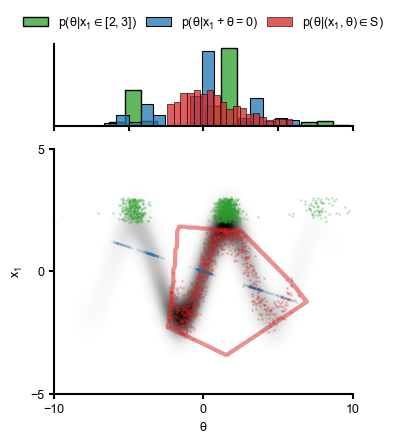

In [539]:
# from scoresbibm.plot import use_style
with use_style("pyloric"):

    fig, axs = plt.subplots(2, 1, figsize=(4., 4.5), gridspec_kw={'height_ratios': [1, 3]})

    # 2D scatter plot
    l = axs[1].contour(X, Y, Z,colors="tab:red", levels=[0.4], alpha=0.5, linewidths=3)
    axs[1].contourf(X, Y, Z_true, cmap="Greys", levels=200, vmin=0, alpha=0.9)
    axs[1].scatter(samples1[:, -1, 0], samples1[:, -1, 1], s=1, alpha=0.2, color="tab:green")
    axs[1].scatter(samples2[:, -1, 0], samples2[:, -1, 1], s=1, alpha=0.05, color="tab:blue")
    axs[1].scatter(samples3[:, -1, 0], samples3[:, -1, 1], s=1, alpha=0.2, color="tab:red")
    axs[1].set_xlim(-10, 10)
    axs[1].set_ylim(-5, 5)
    axs[1].set_xlabel(r"$\theta$")
    axs[1].set_ylabel(r"$x_1$")

    # 1D marginal plot
    _ = sns.histplot(samples1[:, -1, 0], ax=axs[0], bins=20, color="tab:green", stat="density")
    _ = sns.histplot(samples2[:, -1, 0], ax=axs[0], bins=20,color="tab:blue", stat="density")
    _ = sns.histplot(samples3[:, -1, 0], ax=axs[0],bins=20, color="tab:red", stat="density")
    axs[0].set_xlim(-10, 10)
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])
    axs[0].set_ylabel("")
    axs[0].yaxis.set_visible(False)
    axs[1].set_xticks([-10,0,10])
    axs[1].set_yticks([-5,0,5])
    
    axs[0].legend([r"$p(\theta|x_1 \in [2,3])$", r"$p(\theta|x_1 + \theta = 0)$", r"$p(\theta|(x_1,\theta)\in S)$"], ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.5),columnspacing=0.7)
    plt.tight_layout()
    plt.show()
    fig.savefig("scoresbi_constraint_conditioning.svg", dpi=300, bbox_inches="tight", pad_inches=0.0)

### Detecting the learned dependency structure

For this we simply require to look at the expected 



In [25]:
xs = generate_data(jrandom.PRNGKey(0), 100)

In [83]:
scores = model_fn(params, jnp.ones(1)*0.0001, xs.reshape(-1, 2, 1), node_ids=jnp.array([0,1], dtype=int), condition_mask=jnp.array([0,0], dtype=int), edge_mask=jnp.array([[1,1], [1,1]]))

In [84]:
jnp.mean(scores * jnp.transpose(scores, (0,2,1)), 0)

Array([[ 161.936, -145.581],
       [-145.581,  445.345]], dtype=float32)

In [88]:
Js = jax.vmap(jax.jacobian(lambda x: model_fn(params, jnp.ones(1)*1e-5, x.reshape(-1, 2, 1), node_ids=jnp.array([0,1], dtype=int), condition_mask=jnp.array([0,0], dtype=int), edge_mask=jnp.array([[1,1], [1,1]]))))(xs[:, :2])

In [89]:
FIM = Js.mean(0).reshape(2,2)

In [91]:
FIM

Array([[-9.787, -0.527],
       [-1.03 , -6.752]], dtype=float32)

### Causal inference

The difference between **conditioning** and **interventions** i.e. $p(\theta|x=1)$ and $p(\theta|do(x=1))$. Is that the latter requires removing incoming edges to $x$. We can do this!

In let's assume the causal model $\theta \rightarrow x$ then:
- $p(\theta|do(x=1)) = p(\theta)$, yet $p(\theta|x=1) \neq p(\theta|x=1)$
- $p(x=1|\theta) = p(x=1|\theta)$ and $p(x=1|\theta) \neq p(x=1|\theta)$


In [430]:
# We can also visualize that the masking works by investigating the jacbian of the model function
# Masking out an off diagonal entry should result in a zero jacobian entry at that position
jax.jacobian(lambda x: model_fn(params, jnp.ones(1)*0.1, x.reshape(-1, 2, 1), node_ids=jnp.array([0,1], dtype=int), condition_mask=jnp.array([0,0], dtype=int), edge_mask=jnp.array([[1,0], [1,1]])))(jnp.ones((2,)))

Array([[[[-0.712,  0.   ]],

        [[ 1.539, -2.18 ]]]], dtype=float32)

(<seaborn.axisgrid.JointGrid at 0x7fcea4a31e70>,
 [<Axes: xlabel='None', ylabel='None'>,
  <Axes: xlabel='None', ylabel='Count'>,
  <Axes: xlabel='Count', ylabel='None'>])

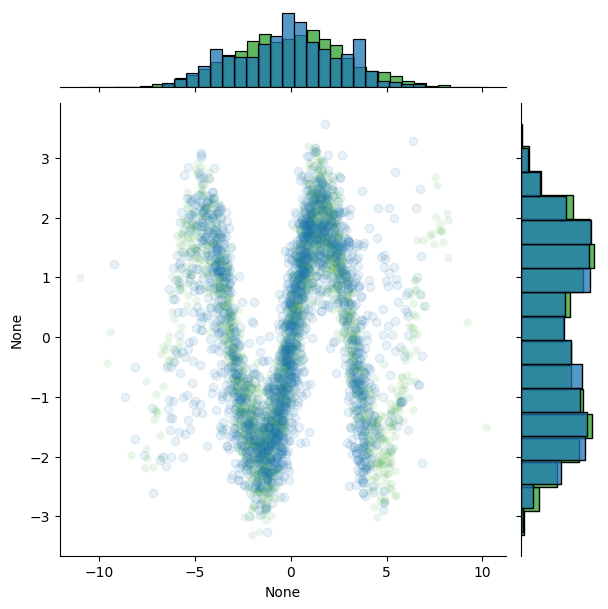

In [431]:
# Joint plot under causal model theta -> x (works, it just identifies the right direction, but does not have to be!)

samples = sample_fn(jrandom.PRNGKey(0), (2000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,0], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=jnp.array([[1,1], [0,1]]), score_fn =model_fn)
plot2(data, samples)

(<seaborn.axisgrid.JointGrid at 0x7fcea40e4f10>,
 [<Axes: xlabel='None', ylabel='None'>,
  <Axes: xlabel='None', ylabel='Count'>,
  <Axes: xlabel='Count', ylabel='None'>])

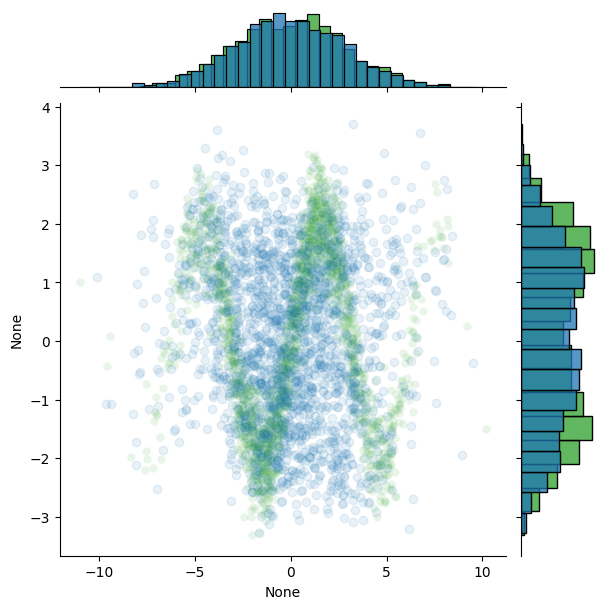

In [432]:
# Joint plot under causal model theta <- x does not work
samples = sample_fn(jrandom.PRNGKey(0), (2000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,0], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=jnp.array([[1,0], [1,1]]), score_fn =model_fn)
plot2(data, samples)

(<seaborn.axisgrid.JointGrid at 0x7fcec4f79ae0>,
 [<Axes: xlabel='None', ylabel='None'>,
  <Axes: xlabel='None', ylabel='Count'>,
  <Axes: xlabel='Count', ylabel='None'>])

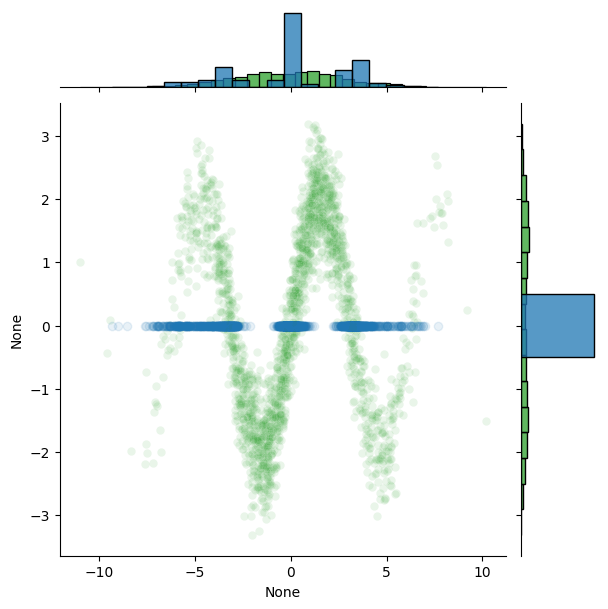

In [433]:
# Conditioning under right causal model works

samples = sample_fn(jrandom.PRNGKey(0), (2000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=jnp.array([[1,1], [0,1]]), score_fn =model_fn)
plot2(data, samples)

(<seaborn.axisgrid.JointGrid at 0x7fcee76c74f0>,
 [<Axes: xlabel='None', ylabel='None'>,
  <Axes: xlabel='None', ylabel='Count'>,
  <Axes: xlabel='Count', ylabel='None'>])

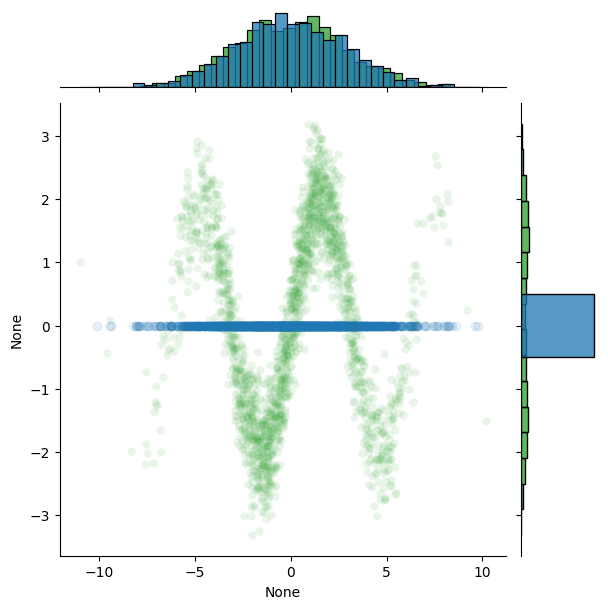

In [30]:
# Causal intervention under correct causal model -> Remove the edge from 1 to 0
# Shoud result in the prior! (Does work)
samples = sample_fn(jrandom.PRNGKey(0), (2000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=jnp.array([[1,0], [0,1]]), score_fn =model_fn)
plot2(data, samples)

#### Change Gaussian priors or likelihoods


$$ p(\theta) \propto \exp\left(-\frac{(\theta - \mu)^2}{2\sigma^2}\right) $$
$$ \nabla_\theta \log p(\theta) = \frac{\theta - \mu}{\sigma^2} $$

In training we have $\sigma^2 = 9$.
Now for any $\alpha$ we have
$$ p(\theta)^\alpha = \exp\left(-\frac{\alpha(\theta - \mu)^2}{2\sigma^2}\right) = \exp\left(-\frac{(\theta - \mu)^2}{2\sigma^2/\alpha}\right) $$

So if we want a certain variance $\sigma_0^2$. All we have to do is to multiply the score by $\alpha = \sigma^2/\sigma_0^2$.

If we want to change the mean then we have to add $\mu_0 - \mu / \sigma^2$ to the score.

In [436]:
def score_prior_change(params, t, x, node_ids, condition_mask, edge_mask, node_ids_to_change, scale=1., shift=0.):

    index = jnp.searchsorted(node_ids,node_ids_to_change)    
    score_unconditioned = model_fn(params, t, x[:,index], node_ids=node_ids_to_change, condition_mask=jnp.zeros_like(node_ids_to_change))

    score_conditional = model_fn(params, t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=edge_mask)
    score_conditional = score_conditional.at[:,index].set(scale * (score_unconditioned - shift) + (score_conditional[:,index] - score_unconditioned))
    
    return score_conditional

def score_likelihood_change(params, t, x, node_ids, condition_mask, edge_mask, node_ids_to_change, scale=1., shift=0.):

    index = jnp.searchsorted(node_ids,node_ids_to_change)    
    score_unconditioned = model_fn(params, t, x[:,index], node_ids=node_ids_to_change, condition_mask=jnp.zeros_like(node_ids_to_change))

    score_conditional = model_fn(params, t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=edge_mask)
    score_conditional =  score_conditional.at[:,index].set(score_unconditioned + (scale*(score_conditional[:,index] - score_unconditioned)) - shift)
    
    return score_conditional


In [545]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, mean_scale=jnp.sqrt(12.))
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


/tmp/ipykernel_5056/2674575355.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  potential_post = potential_post / jnp.trapz(potential_post, x=x)


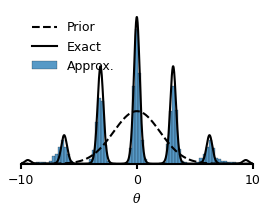

In [546]:
# Change to N(0, 2) prior -> shift = 9/4
score_fn_prior_change = partial(score_prior_change, scale=9/12., shift=0., node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (5000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_prior_change)
with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=100, stat="density", label= "Approx.")
    plt.plot(x, jax.scipy.stats.norm.pdf(x, 0, 2), color="black", linestyle="--", label="Prior")
    plt.plot(x, potential_post, color="black", label="Exact")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\theta$")
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    ax.set_xlim(-10,10)
    plt.savefig("scoresbi_prior_change.svg", dpi=300, bbox_inches="tight", pad_inches=0.0)

In [516]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, mean_scale=1, mean_loc=2)
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


/tmp/ipykernel_5056/586400139.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  potential_post = potential_post / jnp.trapz(potential_post, x=x)


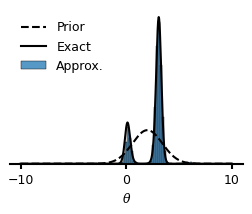

In [517]:
# Change to N(2, 1) prior -> shift = 9/2, loc = 2/9
score_fn_prior_change = partial(score_prior_change, scale=9/2, shift=-2/9, node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (2000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_prior_change)

with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=50, stat="density", label= "Approx.")
    plt.plot(x, jax.scipy.stats.norm.pdf(x, 2., np.sqrt(2.)), color="black", linestyle="--", label="Prior")
    plt.plot(x, potential_post, color="black", label="Exact")
    plt.legend()
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    plt.xlabel(r"$\theta$")
    plt.savefig("scoresbi_prior_change2.svg", dpi=300, bbox_inches="tight", pad_inches=0.0)

In [547]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, sigma_x1=jnp.sqrt(0.05))
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


/tmp/ipykernel_5056/3693902762.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  potential_post = potential_post / jnp.trapz(potential_post, x=x)


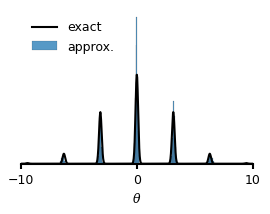

In [548]:
# Likelihood very certain
score_fn_likelihood_change = partial(score_likelihood_change, scale=0.5**2/0.05, shift=0., node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (2000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_likelihood_change)

with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=200, stat="density")
    plt.plot(x, potential_post, color="black")
    plt.legend(["exact", "approx."], loc="upper left")
    plt.xlim(-10,10)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    plt.xlabel(r"$\theta$")
    plt.savefig("scoresbi_likelihood_change.svg", dpi=300, bbox_inches="tight", pad_inches=0.0)

In [531]:
x = jnp.linspace(-10, 10, 1000)
potential_theta = partial(log_potential, x1=jnp.zeros((1,)), x2=None, sigma_x1=2.)
potential_post = potential_theta(x)
potential_post = potential_post - potential_post.max()
potential_post = jnp.exp(potential_post)
potential_post = potential_post / jnp.trapz(potential_post, x=x)


/tmp/ipykernel_5056/4120217402.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  potential_post = potential_post / jnp.trapz(potential_post, x=x)


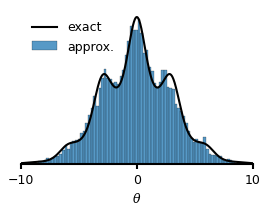

In [532]:
# Likelihood very certain
score_fn_likelihood_change = partial(score_likelihood_change, scale=0.5**2/4., shift=0., node_ids_to_change=jnp.array([0]))
samples = sample_fn(jrandom.PRNGKey(0), (10000,), time_steps=500, node_ids=jnp.array([0,1]), condition_mask=jnp.array([0,1], dtype=int), condition_value=jnp.zeros((2,)),  edge_mask=None, score_fn =score_fn_likelihood_change)

with use_style("pyloric"):
    fig = plt.figure(figsize=(3, 2))
    ax = plt.gca()
    sns.histplot(samples[:, -1, 0], bins=100, stat="density")
    plt.plot(x, potential_post, color="black")
    plt.legend(["exact", "approx."], loc="upper left")
    plt.xlim(-10,10)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([-10,0,10])   
    plt.xlabel(r"$\theta$")
    plt.savefig("scoresbi_likelihood_change2.svg", dpi=300, bbox_inches="tight", pad_inches=0.0)